In [90]:
###### import commands
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.utils import resample

In [91]:
#### read model
df=pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory=False)
df=df.set_index('ticket_id')


In [92]:
df.iloc[0]

agency_name                      Buildings, Safety Engineering & Env Department
inspector_name                                                  Sims, Martinzie
violator_name                                 INVESTMENT INC., MIDWEST MORTGAGE
violation_street_number                                                    2900
violation_street_name                                                     TYLER
violation_zip_code                                                          NaN
mailing_address_str_number                                                    3
mailing_address_str_name                                              S. WICKER
city                                                                    CHICAGO
state                                                                        IL
zip_code                                                                  60606
non_us_str_code                                                             NaN
country                                 

In [93]:
# drop bad columns
df=df.dropna(axis='columns',thresh=len(df)*1/4)

dfOG=df.copy()

In [94]:
#### create new feature - time difference between ticket and hearing dates
tdiff=pd.to_datetime(dfOG['hearing_date'])-pd.to_datetime(dfOG['ticket_issued_date'])
dfOG['TimeDiff']=tdiff.dt.total_seconds()/86400

In [95]:
#### add month feature for issue and hearing date, also day and weekday
dfOG['hearing_month']=pd.to_datetime(dfOG['hearing_date']).dt.month
dfOG['issue_month']=pd.to_datetime(dfOG['ticket_issued_date']).dt.month

dfOG['hearing_day']=pd.to_datetime(dfOG['hearing_date']).dt.day
dfOG['issue_day']=pd.to_datetime(dfOG['ticket_issued_date']).dt.day

dfOG['hearing_dayofweek']=pd.to_datetime(dfOG['hearing_date']).dt.weekday
dfOG['issue_dayofweek']=pd.to_datetime(dfOG['ticket_issued_date']).dt.weekday


In [96]:
#### read latlon, addresses
latlon_df=pd.read_csv('latlons.csv')
add_df=pd.read_csv('addresses.csv')
add_df['address'] = add_df['address'].str.upper()

In [97]:
#### merge latlon, addresses on addresses column

# latlon_df['address']
latlon_df['address'] = latlon_df['address'].str.upper()
latlon_df.head()

df_info=add_df.merge(latlon_df,left_on='address',right_on='address')
df_info=df_info.set_index('ticket_id')
print('add={:d} + ll={:d} = {:d}'.format(len(add_df),len(latlon_df),len(df_info)))

# there should be 8 rows with nan lat/lon
# df_info['lon'].isna().sum() # =8
# df_info.head()


add=311307 + ll=121769 = 311307


In [98]:
#### merge latlon info into main df
df2=dfOG.merge(df_info,left_index=True,right_index=True, how='left')
print('og={:d} + info={:d} = {:d}'.format(len(dfOG),len(df_info),len(df2)))
dfOG=df2.copy()
df=df2.copy()

og=250306 + info=311307 = 250306


In [99]:
## what types of data are in here? the 'compliance' column is the target value (0 or 1)
y=df['compliance']
X=df.drop(['compliance'],axis=1)
X.iloc[0]

agency_name                      Buildings, Safety Engineering & Env Department
inspector_name                                                  Sims, Martinzie
violator_name                                 INVESTMENT INC., MIDWEST MORTGAGE
violation_street_number                                                    2900
violation_street_name                                                     TYLER
mailing_address_str_number                                                    3
mailing_address_str_name                                              S. WICKER
city                                                                    CHICAGO
state                                                                        IL
zip_code                                                                  60606
country                                                                     USA
ticket_issued_date                                          2004-03-16 11:40:00
hearing_date                            

In [26]:
## what is the cardinality of each column?
for col in X.columns:
    print('{} - {}'.format(col,len(X[col].value_counts())))
    
# for col in df.columns:
#     print('{} - {}'.format(col,len(df[col].value_counts())))
    

agency_name - 5
inspector_name - 173
violator_name - 119992
violation_street_number - 19175
violation_street_name - 1791
mailing_address_str_number - 15826
mailing_address_str_name - 37896
city - 5184
state - 59
zip_code - 4251
country - 5
ticket_issued_date - 86979
hearing_date - 6222
violation_code - 235
violation_description - 258
disposition - 9
fine_amount - 43
admin_fee - 2
state_fee - 2
late_fee - 37
discount_amount - 13
clean_up_cost - 1
judgment_amount - 57
payment_amount - 533
balance_due - 606
payment_status - 3
compliance_detail - 10
TimeDiff - 33217
hearing_month - 12
issue_month - 12
hearing_day - 31
issue_day - 31
hearing_dayofweek - 6
issue_dayofweek - 7
address - 95598
lat - 78694
lon - 87249


In [87]:
# good ones - ['discount_amount', 'disposition', ]

## print out ratio of compliance to non-compliance for each category within each feature
# some that stand out: 
# violator_name - Acorn investment and others are from 'king of detroit blight': 
# https://www.crainsdetroit.com/article/20161016/NEWS/161019896/state-law-cant-stop-king-of-detroit-blight
# address - PO Box 213 in Southfield is also from the 'blight king'
# disposition - pretty strong variance, seems like data leakage, but this is included in the competition test set
# fine_amount - larger fines -> less likely to pay
# late_fee - data leakage again, but is allowed - if 0, higher likelihood of compliance
# discount_amount - data leakage, if there is a discount, high likelihood of compliance
# for var in X.columns:
# #     var='agency_name'


#     ctTot=pd.crosstab(X[var], y, margins=True)
#     ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
# #     ctNorm
#     # X.issue_day.value_counts()
#     ctNorm['N']=X[(y==1) | (y==0)][var].value_counts() # not great, should merge on keys instead of assuming everything lines up
#     ctNorm['Nall']=X[var].value_counts()
#     print(ctNorm.sort_values(by=['N'], ascending=False))
# ctNorm

var='violator_name'
# ctTot=pd.crosstab(X[var], y, margins=True)
ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
ctNorm['N']=X[(y==1) | (y==0)][var].value_counts() # not great, should merge on keys instead of assuming everything lines up
ctNorm['Nall']=X[var].value_counts()
print(ctNorm.sort_values(by=['N'], ascending=False))
ctNorm

compliance                                   0.0       1.0      N   Nall
violator_name                                                           
INVESTMENT, ACORN                       1.000000  0.000000  624.0  809.0
INVESTMENT CO., ACORN                   1.000000  0.000000  343.0  425.0
BANK, WELLS FARGO                       0.980237  0.019763  253.0  328.0
MILLER, JOHN                            0.994350  0.005650  177.0  205.0
STEHLIK, JERRY                          0.867089  0.132911  158.0  162.0
NEW YORK, BANK OF                       0.971831  0.028169  142.0  184.0
KRAMER, KEITH                           1.000000  0.000000  119.0  137.0
SNOW, GEORGE                            1.000000  0.000000  108.0  147.0
NATIONAL TRUST CO., DEUTSCHE BANK       0.980392  0.019608  102.0  122.0
APARTMENTS, CARLTON                     1.000000  0.000000  102.0  139.0
ROSEN, NATHAN                           0.959184  0.040816   98.0  110.0
PRESTIGE, KMG                           1.000000  0

compliance,0.0,1.0,N,Nall
violator_name,,,,
"# 1, ESTATE",1.000000,0.000000,1.0,1.0
"# 2 DEBORAH CARDENAS, BANK OF AMERICA",1.000000,0.000000,1.0,1.0
"# 4526, RITE-AID",0.000000,1.000000,1.0,1.0
"#1 INC., SIMPLY REAR",1.000000,0.000000,1.0,1.0
"#1, ESTATE",1.000000,0.000000,4.0,4.0
"#10286, BURGER KING",1.000000,0.000000,1.0,1.0
"#10437, BURGER KING",1.000000,0.000000,1.0,1.0
"#11686, Subway",1.000000,0.000000,1.0,1.0
"#11782, SUBWAY",1.000000,0.000000,1.0,1.0


In [89]:
var='violator_name'
# ctTot=pd.crosstab(X[var], y, margins=True)
ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
ctNorm['N']=X[(y==1) | (y==0)][var].value_counts() # not great, should merge on keys instead of assuming everything lines up
# ctNorm['Nall']=X[var].value_counts()
print(ctNorm[ctNorm['N']>100].sort_values(by=['N'], ascending=False))

compliance                              0.0       1.0      N
violator_name                                               
INVESTMENT, ACORN                  1.000000  0.000000  624.0
INVESTMENT CO., ACORN              1.000000  0.000000  343.0
BANK, WELLS FARGO                  0.980237  0.019763  253.0
MILLER, JOHN                       0.994350  0.005650  177.0
STEHLIK, JERRY                     0.867089  0.132911  158.0
NEW YORK, BANK OF                  0.971831  0.028169  142.0
KRAMER, KEITH                      1.000000  0.000000  119.0
SNOW, GEORGE                       1.000000  0.000000  108.0
APARTMENTS, CARLTON                1.000000  0.000000  102.0
NATIONAL TRUST CO., DEUTSCHE BANK  0.980392  0.019608  102.0


compliance        0.0       1.0        N
fine_amount                             
0.0          0.000000  1.000000    195.0
25.0         0.922351  0.077649   1378.0
50.0         0.909380  0.090620  20415.0
100.0        0.882877  0.117123  15488.0
125.0        0.949559  0.050441    793.0
200.0        0.900000  0.100000  12710.0
250.0        0.936899  0.063101  86798.0
300.0        0.971603  0.028397   3768.0
350.0        0.953125  0.046875    128.0
500.0        0.945938  0.054062   6918.0
750.0        0.938865  0.061135    229.0
1000.0       0.962538  0.037462   4965.0
1500.0       0.943182  0.056818    264.0
2500.0       0.970227  0.029773   1545.0
3500.0       0.979269  0.020731   3859.0
10000.0      0.994872  0.005128    195.0


<IPython.core.display.Javascript object>


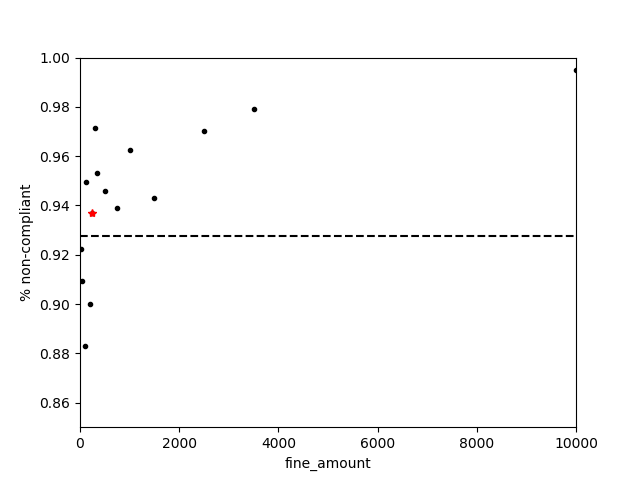

In [86]:


var='fine_amount' # define the column to examine
ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
ctNorm['N']=X[(y==1) | (y==0)][var].value_counts()
print(ctNorm[ctNorm['N']>100]) # just show the values that have over 100 observation to reduce noise

import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(ctNorm[ctNorm['N']>100].index,ctNorm[ctNorm['N']>100][0.0],'k.')
maxind=ctNorm['N'].idxmax() # find the index that has the most observations
plt.plot(maxind,ctNorm.loc[maxind,0.0],'r*')
avgval=ctNorm.loc['All',0.0] # the average non-compliance for all violations
plt.plot([0,np.max(X[var])],[avgval,avgval],'k--')
plt.axis((0,np.max(X[var]),.85,1))
plt.xlabel(var)
plt.ylabel('% non-compliant')
plt.show()

plt.savefig('fine_amount.jpg',dpi=200)

# ctNorm.loc['All',0.0]*[1,1]
# ctNorm.loc[250.0,0.0]
# ctNorm.iloc[ctNorm['N'].argmax]
# ctNorm['N'].idxmax()
# np.max(X[var])
# list(ctNorm.index)
# fig = plt.figure()

# ax = fig.add_subplot(111)
# ax.set_title(var)
# ax.

In [33]:
X[(y==1) | (y==0)][var].value_counts()

250.0      86798
50.0       20415
100.0      15488
200.0      12710
500.0       6918
1000.0      4965
3500.0      3859
300.0       3768
2500.0      1545
25.0        1378
125.0        793
1500.0       264
750.0        229
0.0          195
10000.0      195
350.0        128
5000.0        85
1200.0        40
400.0         39
2000.0        16
7000.0        13
600.0         10
220.0          4
3000.0         4
1250.0         2
95.0           2
1750.0         2
150.0          2
160.0          2
450.0          1
20.0           1
655.0          1
2695.0         1
677.0          1
170.0          1
8000.0         1
270.0          1
1.0            1
970.0          1
1030.0         1
Name: fine_amount, dtype: int64

In [14]:
# ctTot=pd.crosstab(X['violation_zip_code'], y, margins=True)
# len(X['grafitti_status'].value_counts())
var='discount_amount'
ctTot=pd.crosstab(X[var], y, margins=True)
ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
#     ctNorm
# X.issue_day.value_counts()
ctNorm['N']=X[var].value_counts()
ctTot

compliance,0.0,1.0,All
discount_amount,,,
0.0,148226,10474,158700
3.0,0,19,19
5.0,8,159,167
10.0,14,141,155
13.0,0,1,1
20.0,13,122,135
25.0,18,587,605
30.0,0,17,17
40.0,0,1,1


250306

In [25]:
## Get ready to plot bar graphs comparing compliant and non-compliant groups for different columns
# first split into compliant and non-compliant (this leaves out ~90k that are null - not responsible)
Xall=X.loc[(y==1) | (y==0)] # not null
yall=y[(y==1) | (y==0)]
X1=X.loc[y==1]
X0=X.loc[y==0]
y1=y[y==1]
y0=y[y==0]
# X0=X.loc[y==0] # non-compliant

print("Compliant: {}, non-compliant: {}, all: {}".format(len(X1),len(X0),len(Xall)))

# define column name
var='fine_amount'

# what are the unique values of this column
# vals=Xall[var].unique()
v1=X1[var].value_counts()
v0=X0[var].value_counts()

vcomb=pd.DataFrame(dict(noncomp=v0,comp=v1))
vcomb=vcomb.fillna(0)

vals=vcomb.index
vcomb


Compliant: 11597, non-compliant: 148283, all: 159880


,noncomp,comp
0.0,0.0,195.0
1.0,0.0,1.0
20.0,0.0,1.0
25.0,1271.0,107.0
50.0,18565.0,1850.0
95.0,2.0,0.0
100.0,13674.0,1814.0
125.0,753.0,40.0
150.0,1.0,1.0
160.0,2.0,0.0


<IPython.core.display.Javascript object>


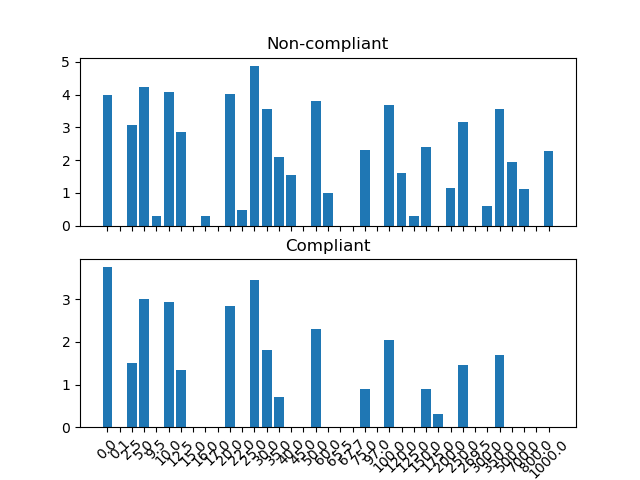

/Users/ulberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/ulberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


Float64Index([   0.0,    0.1,    2.5,    5.0,    9.5,   10.0,   12.5,   15.0,
                16.0,   17.0,   20.0,   22.0,   25.0,   30.0,   35.0,   40.0,
                45.0,   50.0,   60.0,   65.5,   67.7,   75.0,   97.0,  100.0,
               120.0,  125.0,  150.0,  175.0,  200.0,  250.0,  269.5,  300.0,
               350.0,  500.0,  700.0,  800.0, 1000.0],
             dtype='float64')

In [16]:
# bar plot comparing two sets
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

xpos=np.arange(len(vals))

# scaled by max value
# fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,sharey=True)

# ax1.bar(xpos,(vcomb['noncomp']/np.max(vcomb['noncomp'])))
# ax1.set_title('Non-compliant')

# ax2.bar(xpos,(vcomb['comp']/np.max(vcomb['comp'])))
# ax2.set_title('Compliant')

# log10 of values, not very accurate for comparison
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)

ax1.bar(xpos,np.log10(vcomb['noncomp']))
ax1.set_title('Non-compliant')

ax2.bar(xpos,np.log10(vcomb['comp']))
ax2.set_title('Compliant')
ax2.set_xticks(xpos)
ax2.set_xticklabels(vals)
ax2.xaxis.set_tick_params(rotation=45)

vals

In [17]:
pd.DataFrame(dict(noncomp=v0,comp=v1))


,noncomp,comp
0.0,9856.0,5602.0
0.1,NaN,1.0
2.5,1191.0,32.0
5.0,16642.0,1013.0
9.5,2.0,NaN
10.0,11645.0,871.0
12.5,701.0,22.0
15.0,1.0,NaN
16.0,2.0,NaN
17.0,1.0,NaN


In [18]:
# X['violator_name'].value_counts()
Xtmp=X.loc[X['fine_amount']==10000]

## find mode of this subset
from statistics import mode 
for col in Xtmp.columns:
    # first get mode
    x1=Xtmp[col].value_counts()
    x2=X[col].value_counts()
    xall=pd.DataFrame(dict(sml=x1, big=x2)).reset_index()
    
    print('************** ' + col + ' **************')
    print(x1)
#     print('{} {}'.format(col,xx))


************** agency_name **************
Department of Public Works    305
Health Department              36
Detroit Police Department      15
Neighborhood City Halls         1
Name: agency_name, dtype: int64
************** inspector_name **************
Hayes, Billy J         85
Zizi, Josue            45
Tidwell, Rhonda        22
Langston, Yolanda      18
Davis, Darlene         16
Frazier, Willie        14
Cato, Valesta          13
Williamson, Lillett    12
Havard, Jacqueline     12
Brooks, Eric           11
Buchanan, Daryl        10
Jones, Derron M         9
Houston, Doris          9
Johnson, Lois           9
Moore, David            8
Gibson, Christopher     6
Funchess, Mitchell      5
McClain, Melvin         4
Traylor, Alva           4
McCants, Angela         4
Carver, Gharian         4
OBannon, James          3
Lusk, Gertrina          3
Jones, Leah             3
Gray, Paul              3
Mathis, Marlena         2
Talbert, Reginald       2
Snyder, Derrell         2
Thornton, Vaughn 

************** zip_code **************
48227         25
48235         20
48228         16
48219         15
48205         13
48037         12
48224         12
48209         10
48223          9
48204          8
48076          7
48238          6
48234          6
48034          6
48213          6
48075          6
48202          5
48322          5
48221          5
76137          5
48206          5
48126          4
48207          4
48217          4
48215          4
48210          3
91730          3
33146          3
48098          3
48226          3
              ..
77081          1
13703          1
19054          1
91107          1
75093          1
93065          1
48084          1
48128          1
48260          1
29210          1
48079          1
48025-0431     1
22182          1
84015          1
48324          1
74133          1
48197          1
70709          1
48111          1
43219          1
34116          1
55423          1
92618          1
48180          1
48074          1
29054    

************** issue_month **************
4     43
7     37
3     36
10    34
1     34
6     33
5     30
2     26
9     23
11    21
8     21
12    19
Name: issue_month, dtype: int64
************** hearing_day **************
4.0     21
8.0     17
22.0    17
20.0    16
3.0     16
10.0    13
5.0     13
9.0     13
15.0    13
26.0    12
7.0     12
16.0    11
19.0    11
1.0     11
29.0    11
18.0    11
2.0     10
21.0    10
12.0     9
25.0     9
11.0     9
27.0     9
17.0     9
24.0     9
23.0     7
14.0     7
30.0     6
31.0     5
28.0     5
13.0     4
6.0      4
Name: hearing_day, dtype: int64
************** issue_day **************
5     19
11    19
22    17
28    16
14    16
19    15
9     15
10    15
1     14
12    14
18    14
24    14
23    13
7     12
3     12
8     11
13    11
16    11
15    11
30    10
20    10
25    10
26     9
4      9
17     8
21     7
6      7
27     7
29     5
2      3
31     3
Name: issue_day, dtype: int64
************** hearing_dayofweek **************
1.0   

In [185]:
Xall[colnames[5]].value_counts()

305.0      79621
85.0       17655
140.0      12516
250.0      11355
280.0       7177
580.0       6545
1130.0      4803
3880.0      3785
360.0       3680
130.0       2972
80.0        2760
2780.0      1506
230.0       1356
57.5        1223
167.5        723
530.0        373
1680.0       251
855.0        217
0.0          195
11030.0      195
1030.0       162
55.0         155
415.0        126
330.0         88
5530.0        85
3530.0        74
155.0         70
1350.0        40
2530.0        39
470.0         36
2230.0        14
7730.0        13
1530.0        13
780.0         12
690.0         10
3330.0         4
430.0          3
272.0          3
206.0          2
2030.0         2
134.5          2
1955.0         2
380.0          2
1405.0         2
217.0          1
1060.0         1
300.0          1
8830.0         1
1097.0         1
31.1           1
50.0           1
180.0          1
525.0          1
2994.5         1
750.5          1
774.7          1
195.0          1
Name: judgment_amount, dtype: i

<IPython.core.display.Javascript object>


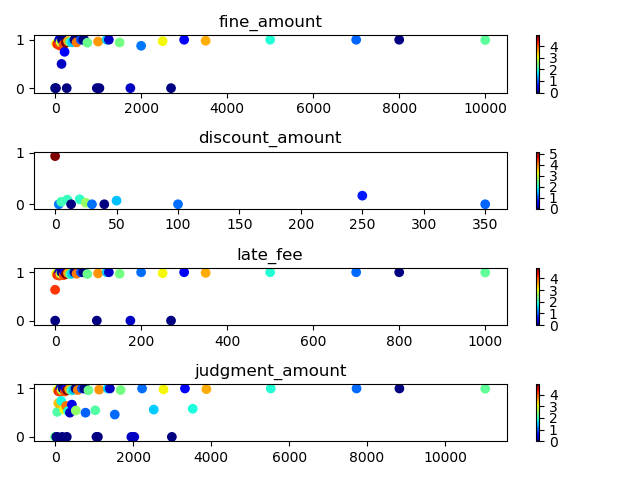

In [19]:
# scatterplots showing percentage non-compliant for different features
# only do numeric ones
colnames=['fine_amount','discount_amount','late_fee','judgment_amount']

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt

cmap=mpl.cm.jet
fig, axes = plt.subplots(len(colnames),1)

for i, col in enumerate(colnames):
    ctTot=pd.crosstab(Xall[col], y, margins=True)
    ctNorm=pd.crosstab(Xall[col], y, normalize='index')
    ctNorm['N']=Xall[col].value_counts()
    
    ax=axes[i]
    sc=ax.scatter(ctNorm.index,ctNorm[0.0],c=np.log10(ctNorm['N']),cmap=cmap)
    ax.set_title(col)
    plt.colorbar(sc,ax=ax)
    
plt.tight_layout()

In [246]:
Xall.columns

Index(['agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'violation_zip_code', 'mailing_address_str_number',
       'mailing_address_str_name', 'city', 'state', 'zip_code',
       'non_us_str_code', 'country', 'ticket_issued_date', 'hearing_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'TimeDiff', 'hearing_month',
       'issue_month', 'hearing_day', 'issue_day', 'hearing_dayofweek',
       'issue_dayofweek', 'address', 'lat', 'lon'],
      dtype='object')

<IPython.core.display.Javascript object>


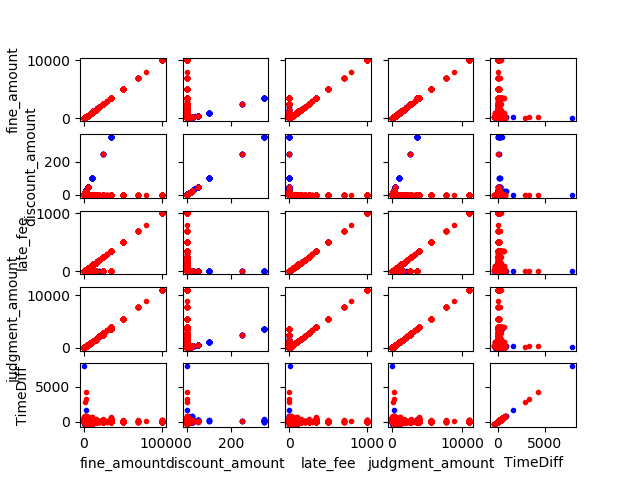

Plotting fine_amount:fine_amount in (0,0)
Plotting fine_amount:discount_amount in (0,1)
Plotting fine_amount:late_fee in (0,2)
Plotting fine_amount:judgment_amount in (0,3)
Plotting fine_amount:TimeDiff in (0,4)
Plotting discount_amount:fine_amount in (1,0)
Plotting discount_amount:discount_amount in (1,1)
Plotting discount_amount:late_fee in (1,2)
Plotting discount_amount:judgment_amount in (1,3)
Plotting discount_amount:TimeDiff in (1,4)
Plotting late_fee:fine_amount in (2,0)
Plotting late_fee:discount_amount in (2,1)
Plotting late_fee:late_fee in (2,2)
Plotting late_fee:judgment_amount in (2,3)
Plotting late_fee:TimeDiff in (2,4)
Plotting judgment_amount:fine_amount in (3,0)
Plotting judgment_amount:discount_amount in (3,1)
Plotting judgment_amount:late_fee in (3,2)
Plotting judgment_amount:judgment_amount in (3,3)
Plotting judgment_amount:TimeDiff in (3,4)
Plotting TimeDiff:fine_amount in (4,0)
Plotting TimeDiff:discount_amount in (4,1)
Plotting TimeDiff:late_fee in (4,2)
Plotting 

In [22]:
# scatterplots comparing the different numeric features
colnames=['fine_amount','discount_amount','late_fee','judgment_amount','TimeDiff']

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt


fig, axes = plt.subplots(len(colnames),len(colnames),sharex='col',sharey='row')

# plot everything against eachother
for i, icol in enumerate(colnames):     # loop over the rows
    for j, jcol in enumerate(colnames): # loop over the columns
        ax=axes[i,j]
        print("Plotting {}:{} in ({},{})".format(icol,jcol,i,j))
        ax.plot(X1[jcol],X1[icol],'b.')
        ax.plot(X0[jcol],X0[icol],'r.')
        
        if i==len(colnames)-1:
            ax.set_xlabel(jcol)
            
        if j==0:
            ax.set_ylabel(icol)


/Users/ulberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


<IPython.core.display.Javascript object>


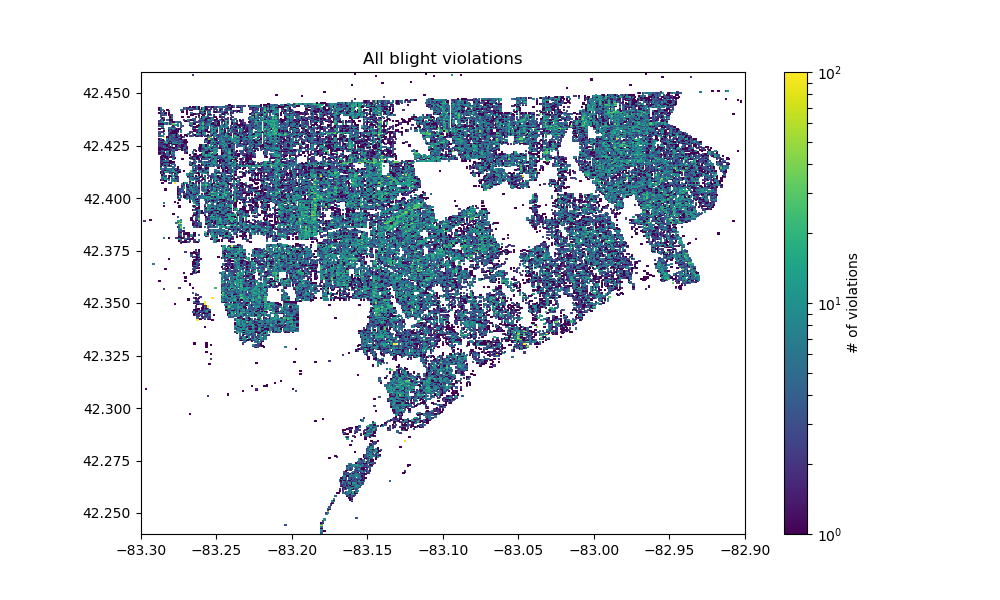

(400, 400), (400, 400), (399, 399)


In [110]:
#### plot spatial data
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

lon1=-83.3
lon2=-82.9
lat1=42.24
lat2=42.46

# lon1=-83.3
# lon2=-83.25
# lat1=42.33
# lat2=42.35

# lon1=-83.265
# lon2=-83.26
# lat1=42.34
# lat2=42.344
xedges=np.linspace(lon1,lon2,400)
yedges=np.linspace(lat1,lat2,400)

H, xedges, yedges = np.histogram2d(X['lon'], X['lat'], bins=(xedges,yedges))

fig = plt.figure(figsize=(10,6))
# fig, axes = plt.subplots(1,1)

ax = fig.add_subplot(111)
ax.set_title('All blight violations')
xx, yy = np.meshgrid(xedges, yedges)
# sc=ax.pcolormesh(xx, yy, np.log10(np.transpose(H)+.01),vmin=0,vmax=2)
sc=ax.pcolormesh(xx, yy, (np.transpose(H)),norm=colors.LogNorm(vmin=1,vmax=100))
# sc=ax.pcolormesh(xx, yy, (np.transpose(H)+.01),vmin=0,vmax=50)
ax.set_aspect(1/np.cos(44* np.pi / 180))
cbar=plt.colorbar(sc,ax=ax)
cbar.ax.set_ylabel("# of violations")
# cbar.ax.set_yscale('log')

# ax=fig.add_subplot(111,projection='3d')
# # xpos,ypos = np.meshgrid(xedges[:-1],yedges[:-1],indexing='ij')

# # ax.bar3d(xpos.flatten(),ypos.flatten(),np.zeros(len(H.flatten())),1,1,H.flatten(),shade=True)

# x_data, y_data = np.meshgrid( np.arange(H.shape[1]),
#                               np.arange(H.shape[0]) )

# # x_data, y_data = np.meshgrid( yedges[:-1],
# #                               xedges[:-1] )
# x_data = x_data.flatten()
# y_data = y_data.flatten()
# z_data = H.flatten()
# ax.bar3d( x_data,
#           y_data,
#           np.zeros(len(z_data)),
#           1, 1, z_data )

plt.show()
plt.savefig('blight_log.jpg',dpi=200)

# check shape of variables
print('{}, {}, {}'.format(xx.shape,yy.shape,H.shape))


/Users/ulberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


<IPython.core.display.Javascript object>


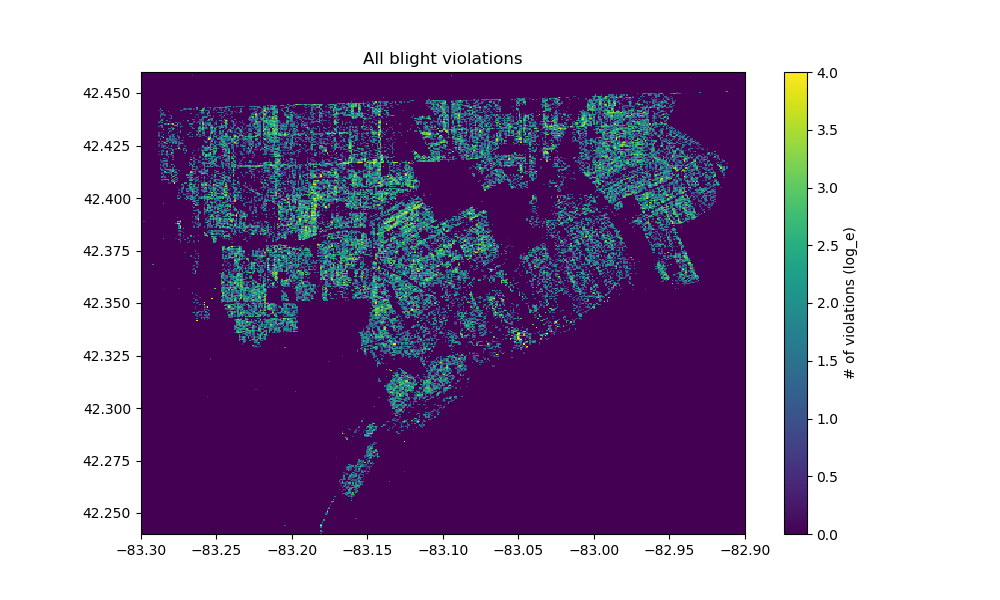

In [194]:
#### plot spatial data, clean version
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# define the map boundaries
lon1=-83.3
lon2=-82.9
lat1=42.24
lat2=42.46

# np histogram will give the number of observations within each 2d bin
xedges=np.linspace(lon1,lon2,400)
yedges=np.linspace(lat1,lat2,400)
H, xedges, yedges = np.histogram2d(X['lon'], X['lat'], bins=(xedges,yedges)) # this throws a warning, I assume because a few of the lat/lon values are nan's, ignoring for now

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

xx, yy = np.meshgrid(xedges, yedges)
sc=ax.pcolormesh(xx, yy, np.log(np.transpose(H)+.01),vmin=0,vmax=4) ## add a floor so log10 won't squawk
ax.set_aspect(1/np.cos(44* np.pi / 180))
ax.set_title('All blight violations')
cbar=plt.colorbar(sc,ax=ax)
cbar.ax.set_ylabel("# of violations (log_e)")

plt.show()
# plt.savefig('blight.jpg',dpi=200)

In [185]:
imax=np.unravel_index(H.argmax(axis=None), H.shape)
print('value {} at {:.4f}, {:.4f}'.format(H[imax],yedges[imax[1]],xedges[imax[0]]))
xtest=xedges[imax[0]]
ytest=yedges[imax[1]]
# a=np.array([[1,2,5],[6, 2, 4],[7, 5, 6],[3,4,5]])
# print(a)
# print(a.argmax())
# imax
print(imax)

value 976.0 at 42.3415, -83.2624
(94, 461)


In [168]:
## find records that are near this location
# set tolerance to be just larger than half the max lat/lon increment amount
tol=np.max([np.max(np.diff(xedges)),np.max(np.diff(yedges))])*1.01

itest=X[(np.abs(X['lon']-xtest)<tol) & (np.abs(X['lat']-ytest)<tol)]
# itest=X[np.abs(X['lon']-xtest)<tol]
print('{}, {}'.format(ytest,xtest))
itest.head()

42.34145363408521, -83.26290726817042


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,...,TimeDiff,hearing_month,issue_month,hearing_day,issue_day,hearing_dayofweek,issue_dayofweek,address,lat,lon
ticket_id,,,,,,,,,,,,,,,,,,,,,
26846,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Al-Musawi, Doha",16331.0,WARREN,16331.0,W. Warren,Detroit,MI,48229,...,190.447917,4.0,10,21.0,13,3.0,2,"16331 WARREN, DETROIT MI",42.341729,-83.262245
18682,"Buildings, Safety Engineering & Env Department","O'Neal, Claude","FARRAN, HISHEM",18300.0,WARREN,183.0,W. WARREN,DETROIT,MI,48228,...,NaN,NaN,1,NaN,18,NaN,1,"18300 WARREN, DETROIT MI",42.341730,-83.262271
18669,"Buildings, Safety Engineering & Env Department","O'Neal, Claude","JACKSON, KIM L",5287.0,IVANHOE,18695.0,WARRINGTON,DETROIT,MI,48221,...,35.187500,2.0,1,22.0,18,1.0,1,"5287 IVANHOE, DETROIT MI",42.341729,-83.262245
18759,"Buildings, Safety Engineering & Env Department","O'Neal, Claude","SEMMA, FOUAD",19345.0,WARREN,19345.0,W. WARREN,DETROIT,MI,48228,...,35.163194,2.0,1,23.0,19,2.0,2,"19345 WARREN, DETROIT MI",42.341729,-83.262245
18758,"Buildings, Safety Engineering & Env Department","O'Neal, Claude","INC., GARY 28744-18750",18750.0,WARREN,1875.0,W. WARREN.,DETROIT,MI,48228,...,13.166667,2.0,1,1.0,19,1.0,2,"18750 WARREN, DETROIT MI",42.341730,-83.262271


In [186]:
# ctTot=pd.crosstab(Xall[col], y, margins=True)
# ctNorm=pd.crosstab(Xall[col], y, normalize='index', margins=True)
# ctNorm['N']=Xall[col].value_counts()
# ctNorm
print(sorted(H.flatten()))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [162]:
np.diff(yedges)


array([0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055138,
       0.00055138, 0.00055138, 0.00055138, 0.00055138, 0.00055

In [24]:
## read test model
dftest=pd.read_csv('test.csv')
dftest=dftest.set_index('ticket_id')

In [25]:
dftest.iloc[0]

agency_name                                          Department of Public Works
inspector_name                                               Granberry, Aisha B
violator_name                                                  FLUELLEN, JOHN A
violation_street_number                                                   10041
violation_street_name                                                 ROSEBERRY
violation_zip_code                                                          NaN
mailing_address_str_number                                                  141
mailing_address_str_name                                              ROSEBERRY
city                                                                    DETROIT
state                                                                        MI
zip_code                                                                  48213
non_us_str_code                                                             NaN
country                                 

In [26]:

var='violator_name'
ctTot=pd.crosstab(X[var], y, margins=True)
ctNorm=pd.crosstab(X[var], y, normalize='index', margins=True)
#     ctNorm
# X.issue_day.value_counts()
ctNorm['N']=X[var].value_counts()
dftmp=dftest[var].value_counts().to_frame(name='Ntest')
ctNorm=ctNorm.merge(dftmp,how='left',left_index=True,right_index=True)

print(ctNorm.sort_values(by=['N'], ascending=False))

                                                   0.0       1.0      N  Ntest
violator_name                                                                 
INVESTMENT, ACORN                             1.000000  0.000000  809.0    NaN
INVESTMENT CO., ACORN                         1.000000  0.000000  425.0    2.0
BANK, WELLS FARGO                             0.980237  0.019763  328.0    6.0
MILLER, JOHN                                  0.994350  0.005650  205.0    NaN
SHIFMAN, ALLEN                                1.000000  0.000000  192.0    NaN
NEW YORK, BANK OF                             0.971831  0.028169  184.0    6.0
COMMISSION, DETROIT HOUSING                   0.983333  0.016667  178.0   19.0
STEHLIK, JERRY                                0.867089  0.132911  162.0    3.0
SNOW, GEORGE                                  1.000000  0.000000  147.0    3.0
APARTMENTS, CARLTON                           1.000000  0.000000  139.0    NaN
TREASURER, WAYNE COUNTY                       0.9523

In [12]:
dftest[dftest['violator_name'].str.contains('ACORN ',na=False)]

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
ticket_id,,,,,,,,,,,,,,,,,,,,,
292653,Department of Public Works,"McClain, Melvin","ACORN INVESTMENT CO.,",6607.0,MONTROSE,NaN,213,P.O. BOX,SOUTHFIELD,MI,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
300551,Department of Public Works,"May, Tanya","ACORN INVESTMENT CO., .",8067.0,CLOVERLAWN,NaN,NaN,P.O. BOX 2103,SOUTHFIELD,MI,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
302292,Department of Public Works,"May, Tanya","ACORN INVESTMENT CO., .",18700.0,GRANDVILLE,NaN,14815,GRANDRIVER,DETROIT,MI,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
302585,Department of Public Works,"Johnson, Lois","ACORN INVESTMENT CO., .",14232.0,GRANDVILLE,NaN,213,P.O. BOX,SOUTHFIELD,MI,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,500.0,20.0,10.0,50.0,0.0,0.0,580.0,NaN
328037,Department of Public Works,"Pickett, Tracine",ACORN INVESTMENT COMPANY,16223.0,LAUDER,48235,P.O. BO,2103,SOUTHFIELD,MI,...,Inoperable motor vehicle(s) one- or two-family...,Responsible by Default,50.0,20.0,10.0,5.0,0.0,0.0,85.0,NaN
333957,Department of Public Works,"Lusk, Gertrina","CO, ACORN INVESTMENT",15387.0,LESURE,NaN,P.O. BO,484,SOUTHFIELD,MI,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,500.0,20.0,10.0,50.0,0.0,0.0,580.0,NaN
333959,Department of Public Works,"Lusk, Gertrina","CO, ACORN INVESTMENT",15387.0,LESURE,NaN,P.O. BO,484,SOUTHFIELD,MI,...,Excessive weeds or plant growth one- or two-fa...,Responsible by Default,50.0,20.0,10.0,5.0,0.0,0.0,85.0,NaN
338648,Department of Public Works,"Carver, Gharian",ACORN INVESTMENT CO,14326.0,FORRER,48227,NaN,PO BOX 484,SOUTHFIELD,MI,...,Excessive weeds or plant growth one- or two-fa...,Responsible by Default,50.0,20.0,10.0,5.0,0.0,0.0,85.0,NaN
337064,Department of Public Works,"Smith, Brittany",ACORN INVESTMENT COMPANY,12392.0,GREENLAWN,48238,213,P.O. BOX,SOUTHFIELD,MI,...,Excessive weeds or plant growth one- or two-fa...,Responsible by Default,50.0,20.0,10.0,5.0,0.0,0.0,85.0,NaN


In [33]:
d1=df[df['mailing_address_str_number']==1].copy()
d1['city']=d1['city'].str.upper()
d1['mailing_address_str_name']=d1['mailing_address_str_name'].str.upper()
# d1.apply(lambda x: x.upper())

In [34]:
d1[d1['mailing_address_str_number']==1]

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,...,TimeDiff,hearing_month,issue_month,hearing_day,issue_day,hearing_dayofweek,issue_dayofweek,address,lat,lon
ticket_id,,,,,,,,,,,,,,,,,,,,,
18871,"Buildings, Safety Engineering & Env Department","Brinkley, Kevin","Corp. #4699, Rite Aid",15875.0,GREENFIELD,1.0,P.O. BOX 8431,HARRISBURG,PA,17105,...,32.958333,2.0,1,22.0,20,1.0,3,"15875 GREENFIELD, DETROIT MI",42.407852,-83.199310
19015,"Buildings, Safety Engineering & Env Department","Rhodes, James","PROPERTIES INC, PAB",8841.0,MICHIGAN AVE,1.0,P.O. BOX 250190,FRANKLIN,MI,48025,...,48.059028,3.0,1,10.0,21,3.0,4,"8841 MICHIGAN AVE, DETROIT MI",42.329302,-83.150225
19123,Department of Public Works,"Cato, Valesta","MORTGAGE ASSOCIATION, FEDERAL NATIONAL",8200.0,WEST PARKWAY,1.0,SOUTH WACKER DR,CHICAGO,IL,60606,...,76.104167,4.0,1,7.0,21,3.0,4,"8200 WEST PARKWAY, DETROIT MI",42.351934,-83.263920
19127,Department of Public Works,"Cato, Valesta","NORTGAGE ASSOCIATION, FEDERAL NATIONAL",8200.0,WEST PARKWAY,1.0,SOUTH WACKER DR,CHICAGO,IL,60606,...,741.041667,2.0,1,1.0,21,3.0,4,"8200 WEST PARKWAY, DETROIT MI",42.351934,-83.263920
19251,"Buildings, Safety Engineering & Env Department","Watson, Jerry","MARTIN, CATHY",3360.0,COLUMBUS,1.0,PO BOX 7061,DEARBORN,MI,48121,...,42.041667,3.0,1,8.0,25,1.0,1,"3360 COLUMBUS, DETROIT MI",42.361356,-83.110669
19243,"Buildings, Safety Engineering & Env Department","Watson, Jerry","COBB, KATHRYN",4303.0,PINGREE,1.0,P.O. BOX 4720,DETROIT,MI,48204,...,42.093750,3.0,1,8.0,25,1.0,1,"4303 PINGREE, DETROIT MI",42.363435,-83.118718
19430,"Buildings, Safety Engineering & Env Department","Rhodes, James","TREANOR, MICHAEL",15762.0,LESURE,1.0,P.O. BOX 174,NORTHVILLE,MI,48167,...,34.979167,3.0,1,2.0,26,2.0,2,"15762 LESURE, DETROIT MI",42.406862,-83.181207
19527,"Buildings, Safety Engineering & Env Department","Keys, Edna","Cox, Junee",18030.0,JAMES COUZENS,1.0,P. O. BOX 19112,DETROIT,MI,48219,...,41.802083,3.0,1,10.0,27,3.0,3,"18030 JAMES COUZENS, DETROIT MI",42.422515,-83.177000
19561,"Buildings, Safety Engineering & Env Department","Watson, Jerry","LEWIS, KENNETH",1641.0,CORTLAND,1.0,PO BOX 8249,DETROIT,MI,48208,...,65.812500,4.0,1,4.0,28,0.0,4,"1641 CORTLAND, DETROIT MI",42.390547,-83.107276


In [284]:
# dftmp=pd.DataFrame(data=dftest[var].value_counts())
dftest[var].value_counts()

HOMES LDHA LP, MLK                                                91
WEEKS, DANA                                                       82
PROPERTIES, LLC, KAY BEE KAY                                      60
MAE, FANNIE                                                       55
FELLOWSHIP ESTATES LLC, -                                         54
DET 123 FUND LLC                                                  48
ARTESIAN EQUITIES LLC, -                                          42
& HERBERT STRATHER, FELLOWSHIP ESTATES LLC C/O WENDELL ANTHONY    39
ARTESIAN EQUITIES LLC                                             38
SUMMIT ACQUISITIONS LLC                                           35
WESTGATE TERRACE APARTMENTS LLC                                   32
TRADIN PLACES LLC                                                 31
SG COMPANIES                                                      29
GLOBAL PREMIER ASSET SERVICING                                    29
FANNIE MAE                        

In [289]:
dftmp=dftest[var].value_counts().to_frame(name='Ntest')

In [326]:
ctNorm[ctNorm.index.str.contains('ACORN',na=False)].sort_values(by=['Ntest','N'], ascending=False)

,0.0,1.0,N,Ntest
violator_name,,,,
"INVESTMENTS, ACORN",1.0,0.0,122.0,7.0
"INVESTMENT CO, ACORN",1.0,0.0,87.0,6.0
"ACORN INVESTMENT CO., .",1.0,0.0,18.0,3.0
"INVESTMENT CO., ACORN",1.0,0.0,425.0,2.0
"CO, ACORN INVESTMENT",1.0,0.0,14.0,2.0
"COMPANY, ACORN INVESTMENT",1.0,0.0,51.0,1.0
"INVESTMENT CO. , ACORN",1.0,0.0,4.0,1.0
"INVESTMENT, ACORN",1.0,0.0,809.0,NaN
"ACORN INVESTMENT, *",1.0,0.0,52.0,NaN


In [294]:
dftmp.index

Index(['HOMES LDHA LP, MLK', 'WEEKS, DANA', 'PROPERTIES, LLC, KAY BEE KAY',
       'MAE, FANNIE', 'FELLOWSHIP ESTATES LLC, -', 'DET 123 FUND LLC',
       'ARTESIAN EQUITIES LLC, -',
       '& HERBERT STRATHER, FELLOWSHIP ESTATES LLC C/O WENDELL ANTHONY',
       'ARTESIAN EQUITIES LLC', 'SUMMIT ACQUISITIONS LLC',
       ...
       'Y&I ASSOCIATES, Y&I', 'RBC CAPITAL HOLDING LLC',
       'SINGH HOUSING & INVESTMENTS LL, .', 'GIBSON, DIQUITA',
       'DEE DOMINGO, AVARSHA LLC', 'INTERESTATE INVESTGROUP LLC, -',
       'Bridge Resource Solutions', 'RC SQUARD, LLC, ...',
       'RENAUD, DAVID & MARY', 'EXPRESS AUTO REPAIR/SAAD NAMO, .'],
      dtype='object', length=38515)

In [31]:
X[X['mailing_address_str_number']==484]

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,...,TimeDiff,hearing_month,issue_month,hearing_day,issue_day,hearing_dayofweek,issue_dayofweek,address,lat,lon
ticket_id,,,,,,,,,,,,,,,,,,,,,
19299,"Buildings, Safety Engineering & Env Department","O'Neal, Claude","CONSTRUCTION, REX",9733.0,YOSEMITE,484.0,P. O. BOX,SOUTHFIELD,MI,48037,...,58.104167,3.0,1,24.0,25,3.0,1,"9733 YOSEMITE, DETROIT MI",42.370310,-83.131875
19406,"Buildings, Safety Engineering & Env Department","Smith, Louis","Management Co., Elm",5558.0,IVANHOE,484.0,PO Box,Southfield,MI,48037,...,47.791667,3.0,1,15.0,26,1.0,2,"5558 IVANHOE, DETROIT MI",42.356444,-83.130103
20425,"Buildings, Safety Engineering & Env Department","Matthews, Delos","CONSTRUCTION, REX",19988.0,HAWTHORNE,484.0,P.O. BOX,DETROIT,MI,48037,...,319.937500,12.0,2,20.0,3,1.0,3,"19988 HAWTHORNE, DETROIT MI",42.441132,-83.092467
21362,"Buildings, Safety Engineering & Env Department","Smith, Louis","Rex Construction, *",14231.0,BENTLER,484.0,P.O. Box,Southfield,MI,48037,...,20.722222,3.0,2,3.0,10,3.0,3,"14231 BENTLER, DETROIT MI",42.390269,-83.251828
21332,"Buildings, Safety Engineering & Env Department","Smith, Louis","Rep. Constructio, *",14231.0,BENTLER,484.0,P.O. Box,Southfield,MI,48037,...,20.753472,3.0,2,3.0,10,3.0,3,"14231 BENTLER, DETROIT MI",42.390269,-83.251828
22166,"Buildings, Safety Engineering & Env Department","Keys, Edna","Rex Construction, *",6320.0,WOODROW,484.0,P.O. Box,Southfield,MI,48037,...,50.864583,4.0,2,7.0,15,3.0,1,"6320 WOODROW, DETROIT MI",42.350209,-83.117422
23989,"Buildings, Safety Engineering & Env Department","O'Neal, Claude","Construction, Rex",10408.0,AURORA,484.0,P.O.Box,Southfield,MI,48037,...,172.968750,8.0,2,17.0,25,2.0,4,"10408 AURORA, DETROIT MI",42.372103,-83.163918
28006,"Buildings, Safety Engineering & Env Department","Keys, Edna","Rex Coast Co., *",12216.0,RUTLAND,484.0,P.O. Box,Southfield,MI,48037,...,93.847222,6.0,3,24.0,22,4.0,1,"12216 RUTLAND, DETROIT MI",42.377110,-83.212986
26362,"Buildings, Safety Engineering & Env Department","Legge, Gerald","Rex Construction, *",4435.0,OREGON,484.0,P.O. Box,Southfield,MI,48037,...,29.135417,4.0,3,20.0,22,2.0,1,"4435 OREGON, DETROIT MI",42.358394,-83.118079
